## Домашнее задание 6
Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import shap
shap.initjs()

import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

from boostaroota import BoostARoota
import os
from copy import deepcopy
from inspect import signature
from typing import List, Optional, Union
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.inspection import permutation_importance


In [2]:
def get_date(ts, base_date_s=None):
    """
    Меняет дату с секунд (от базовой даты) на datetime
    """
    if base_date_s is None:
        base_date_s = dt.datetime.timestamp(
            dt.datetime(year=2017, month=12, day=1))
    return dt.datetime.fromtimestamp(ts + base_date_s)

In [3]:
def transform_x(dfs: list,
                column,
                func,
                new_column=None):
    """
    Создает новый признак new_column на основе признака column, 
    пропущенного через функцию func
    Отрабатывает для всех датасетов в dfs
    """
    if new_column is None:
        new_column = column
    for df in dfs:
        df[new_column] = df[column].apply(func)

In [4]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Обработка категориальных признаков и подготовка матрицы
    признаков для передачи в любой алгоритм машинного обучения.

    Parameters
    ----------
    encoder: callable
        Объект для обработки категориальных признаков;
        объект должен поддерживать sklearn-API.

    categorical_features: List[str]
        Список с названием категориальных признаков.

    na_value: float or str, optional, default = None
        Значение для заполнения пропусков.
        Опциональный параметр, по умолчанию, не используется.

    """
    def __init__(self,
                 encoder: callable,
                 categorical_features: List[str],
                 na_value: Union[int, float, str] = None) -> None:
        self.encoder = encoder
        self.categorical_features = categorical_features
        self.na_value = na_value

        sig = signature(encoder.fit)
        self.nparams = len(sig.parameters)
        self.encoders = None

    def _prepare_data(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Подготовка данных для передачи в модель.

        """
        if self.na_value:
            return X[self.categorical_features].fillna(self.na_value)

        return X

    def _check_unique_values(self, y: pd.Series) -> pd.Series:
        """
        Проверка на ранее не встречающиеся значения признака.
        Если значения встречаются - заменяем на self.na_value,
        если self.na_value - не задан, то заменяем на моду.

        """
        encoder = self.encoders[y.name]
        missed_values = list(
            set(y.unique()) - set(encoder.classes_)
        )

        if missed_values:
            mask = y.isin(missed_values)
            if self.na_value:
                y[mask] = self.na_value
            else:
                mode = y.value_counts()[0].index
                y[mask] = mode

        return y

    def _fit_label_encoder(self, X: pd.DataFrame) -> None:
        """
        Обучение LabelEncoder'ов для всех признаков;

        """
        self.encoders = {}
        for feature in self.categorical_features:
            x = X[feature].astype(str)
            encoder = deepcopy(self.encoder)
            self.encoders[feature] = encoder.fit(x)

        return self

    def _transform_label_encoder(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Применение LabelEncoder'ов для всех признаков;

        """
        for feature in self.categorical_features:
            x = X[feature].astype(str)
            x = self._check_unique_values(x)
            encoder = self.encoders.get(feature)
            X[feature] = encoder.transform(x)

        return X

    def fit(self, X, y=None):
        """
        Обучение encoder'а категориальных признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков.

        y: pandas.core.frame.Series
            Вектор целевой переменной.
            Опциональный параметр, по умолчанию, не требуется.

        Returns
        -------
        self
        """
        X = self._prepare_data(X)
        if self.nparams == 1:
            self._fit_label_encoder(X=X)
        else:
            self.encoder.fit(
                X[self.categorical_features].astype(str), y
            )
        return self

    def transform(self, X, y=None):
        """
        Преобразование категориальных признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков.

        Returns
        -------
        X_transformed: pandas.core.frame.DataFrame
            Преобразованная матрица признаков с
            обработанными категориальными признаками.

        """
        X = self._prepare_data(X)
        if self.encoders:
            categorical = self._transform_label_encoder(X)
        else:
            categorical = self.encoder.transform(
                X[self.categorical_features].astype(str)
            )

        X = X.drop(self.categorical_features, axis=1)
        X = pd.concat([X, categorical], axis=1)

        return X

In [5]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()

    X = pd.get_dummies(X, columns=categorical)
#     X.columns = [col.lower() for col in X.columns]
    
    return X

In [6]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [7]:
data = pd.read_csv('./assignment_2_train.csv')
lb_data = pd.read_csv('./assignment_2_test.csv')

In [8]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
target_name = 'isFraud'

In [10]:
data.shape, lb_data.shape

((180000, 394), (100001, 394))

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [12]:
target = data[target_name]

In [13]:
numerical_features = data.select_dtypes(exclude=["object"]).columns.tolist()
categorical_features = data.select_dtypes(include=["object"]).columns.tolist()

In [14]:
data[categorical_features] = data[categorical_features].astype(str)
lb_data[categorical_features] = lb_data[categorical_features].astype(str)

Заберем данные из 5 урока:

In [15]:
for name in ['x_train_ce', 'x_valid_ce', 'x_test_ce', 'x_LB_ce',
             'y_train', 'y_valid', 'y_test', 'y_LB']:
    globals()[name] = pd.read_csv(f'../les_05/out_dfs/{name}.csv')

In [16]:
x_train_ce.head(1)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,card5_D15_stat,card6_D15_stat,addr1_D15_stat,addr2_D15_stat,card1_2_D15_stat,card1_2_3_5_D15_stat,card1_2_3_5_addr1_2_D15_stat,TransactionAmt_get_int_part,TransactionAmt_get_float_part,TransactionAmt_get_log
0,183461,50.0,7919,194.0,150.0,166.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,0.0,3.912023


In [17]:
models = dict()
model_count = 0
def evaluate(x_train, 
         x_valid, 
         x_test,
         model, 
         x_LB=None,
         metric=roc_auc_score, 
         name=None):
    preds = {
        'pred_train': model.predict_proba(x_train)[:,1],
        'pred_valid': model.predict_proba(x_valid)[:,1],
        'pred_test': model.predict_proba(x_test)[:,1],
    }
    if not x_LB is None:
        preds['pred_LB'](model.predict_proba(x_LB)[:,1])
        
    global model_count
    if name is None:
        name = f'model_{model_count}'
    models[name] = {
        'scores': {
            'train': (metric(y_train, preds['pred_train'])),
            'valid': (metric(y_valid, preds['pred_valid'])),
            'test': (metric(y_test, preds['pred_test'])),
            },
        'preds': preds,
        'model': model
    }
    if not x_LB is None:
        scores[name][scores]['LB']: (metric(y_LB, preds['pred_LB']))
    model_count += 1
    return f'\n{name}:\n{models[name]["scores"]}'

In [18]:
encoder = CategoricalEncoder(
    encoder=CatBoostEncoder(random_state=27),
    categorical_features=categorical_features,
)

#### Задание 0: 
выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [19]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)

In [20]:
def model_fit(model, 
              x_train, 
              y_train, 
              x_valid,
              y_valid,
              x_test,
              name=None):
    eval_sets = [
        (x_train, y_train),
        (x_valid, y_valid)
    ]

    model.fit(
        y=y_train,
        X=x_train,
        eval_set=eval_sets,
    )
    out = evaluate(x_train, x_valid, x_test, model, name=name)
    print(out)

In [21]:
model_fit(model, 
          x_train_ce, 
          y_train, 
          x_valid_ce,
          y_valid,
          x_test_ce,
          name='base_model')

0:	test: 0.6180072	test1: 0.6217056	best: 0.6217056 (0)	total: 296ms	remaining: 59s
100:	test: 0.9445034	test1: 0.8614427	best: 0.8615675 (99)	total: 11.2s	remaining: 11s
199:	test: 0.9528946	test1: 0.8761964	best: 0.8761964 (199)	total: 27s	remaining: 0us

bestTest = 0.8761963844
bestIteration = 199


base_model:
{'train': 0.9528946377591037, 'valid': 0.8761963844078187, 'test': 0.8631454523265747}


#### Задание 1: 
использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Text(0.5, 1.0, 'Feature Importance')

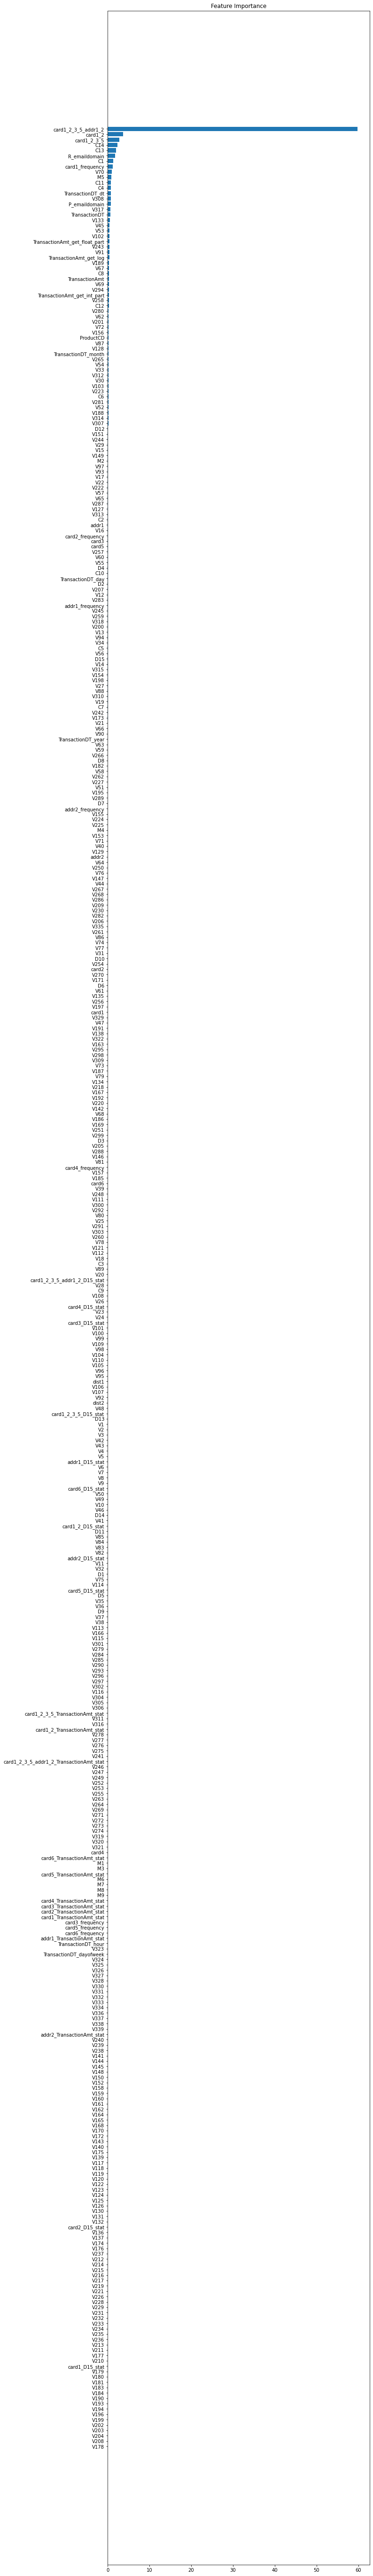

In [22]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 100))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test_ce.columns)[sorted_idx])
plt.title('Feature Importance')

#### Задание 2: 
удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [23]:
feature_importance = pd.DataFrame(feature_importance, 
                                  index=x_train_ce.columns, 
                                  columns=['score'])
feature_importance

,score
TransactionDT,0.617557
TransactionAmt,0.315088
card1,0.007412
card2,0.010390
card3,0.111495
...,...
card1_2_3_5_D15_stat,0.000000
card1_2_3_5_addr1_2_D15_stat,0.000000
TransactionAmt_get_int_part,0.304121
TransactionAmt_get_float_part,0.434279


In [24]:
important_features = feature_importance[feature_importance['score'] > 0.1].index.tolist()
important_features

['TransactionDT',
 'TransactionAmt',
 'card3',
 'card5',
 'addr1',
 'C1',
 'C2',
 'C4',
 'C6',
 'C8',
 'C11',
 'C12',
 'C13',
 'C14',
 'D12',
 'V15',
 'V16',
 'V17',
 'V22',
 'V29',
 'V30',
 'V33',
 'V45',
 'V52',
 'V53',
 'V54',
 'V57',
 'V62',
 'V65',
 'V67',
 'V69',
 'V70',
 'V72',
 'V87',
 'V91',
 'V93',
 'V97',
 'V102',
 'V103',
 'V127',
 'V128',
 'V133',
 'V149',
 'V151',
 'V156',
 'V188',
 'V189',
 'V201',
 'V222',
 'V223',
 'V243',
 'V244',
 'V258',
 'V265',
 'V280',
 'V281',
 'V287',
 'V294',
 'V307',
 'V308',
 'V312',
 'V313',
 'V314',
 'V317',
 'TransactionDT_dt',
 'TransactionDT_month',
 'ProductCD',
 'P_emaildomain',
 'R_emaildomain',
 'M2',
 'M5',
 'card1_2',
 'card1_2_3_5',
 'card1_2_3_5_addr1_2',
 'card1_frequency',
 'card2_frequency',
 'TransactionAmt_get_int_part',
 'TransactionAmt_get_float_part',
 'TransactionAmt_get_log']

In [25]:
model_fit(model, 
          x_train_ce[important_features], 
          y_train, 
          x_valid_ce[important_features],
          y_valid,
          x_test_ce[important_features])

0:	test: 0.8035385	test1: 0.6987623	best: 0.6987623 (0)	total: 75.4ms	remaining: 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8606150192
bestIteration = 17

Shrink model to first 18 iterations.

model_1:
{'train': 0.9290332176851411, 'valid': 0.8606150192457871, 'test': 0.8395446224655241}


оценка только ухудшилась

#### Задание 3: 
использовать permutation importance, выполнить задание 1 и 2.

In [26]:
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

estimator = PermutationImportance(
    model, scoring="roc_auc", random_state=27
)
importance = estimator.fit(x_valid_ce.fillna(-9999), y_valid)

In [27]:
show_weights(importance, 
             feature_names=x_valid_ce.columns.tolist(), 
             top=x_valid_ce.shape[1])

Weight,Feature
0.0166 ± 0.0062,card1_2_3_5_addr1_2
0.0160 ± 0.0025,C14
0.0095 ± 0.0030,M5
0.0062 ± 0.0029,V308
0.0060 ± 0.0025,V91
0.0043 ± 0.0021,card3
0.0038 ± 0.0015,V22
0.0030 ± 0.0026,V317
0.0021 ± 0.0002,TransactionAmt_get_int_part
0.0020 ± 0.0007,R_emaildomain


In [28]:
important_features = feature_importance[feature_importance['score'] > 0.6].index.tolist()
important_features

['TransactionDT',
 'C1',
 'C4',
 'C11',
 'C13',
 'C14',
 'V70',
 'V308',
 'V317',
 'TransactionDT_dt',
 'P_emaildomain',
 'R_emaildomain',
 'M5',
 'card1_2',
 'card1_2_3_5',
 'card1_2_3_5_addr1_2',
 'card1_frequency']

In [29]:
model_fit(model, 
          x_train_ce[important_features], 
          y_train, 
          x_valid_ce[important_features],
          y_valid,
          x_test_ce[important_features])

0:	test: 0.8584313	test1: 0.7354763	best: 0.7354763 (0)	total: 61ms	remaining: 12.1s
100:	test: 0.9451256	test1: 0.8548333	best: 0.8548333 (100)	total: 5.52s	remaining: 5.41s
199:	test: 0.9523556	test1: 0.8652676	best: 0.8652676 (199)	total: 10.7s	remaining: 0us

bestTest = 0.8652675724
bestIteration = 199


model_2:
{'train': 0.9523555571592524, 'valid': 0.8652675723801058, 'test': 0.8632130964626301}


permutation importance же улучшил оценку, но не на много

#### Задание 4: 
использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

In [30]:
data_br = pd.read_csv('./assignment_2_train.csv')
lb_data_br = pd.read_csv('./assignment_2_test.csv')

In [31]:
data_br = prepare_data(data_br)
lb_data_br = prepare_data(lb_data_br)

In [32]:
x_train_br, x_valid_br = train_test_split(
    data_br.drop(["TransactionID", target_name], axis=1), train_size=0.8, shuffle=True, random_state=1,
)
y_train_br, y_valid_br = train_test_split(
    data_br[target_name], train_size=0.8, shuffle=True, random_state=1,
)

x_valid_br, x_test_br = train_test_split(
    x_valid_br, train_size=0.8, shuffle=True, random_state=27
)
y_valid_br, y_test_br = train_test_split(
    y_valid_br, train_size=0.8, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train_br.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid_br.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test_br.shape))

x_train.shape = 144000 rows, 529 cols
x_valid.shape = 28800 rows, 529 cols
x_test.shape = 7200 rows, 529 cols


In [33]:
x_LB_br = lb_data_br.drop(["TransactionID", target_name], axis=1)
y_LB_br = lb_data_br[target_name]

In [34]:
br = BoostARoota(metric='auc',
                cutoff=4,
                iters=10,
                max_rounds=100,
                delta=0.1,
                silent=True)
br.fit(x_train_br, y_train_br)

[19:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [35]:
br.keep_vars_

0       TransactionDT
1      TransactionAmt
2               card1
3               card2
4               card3
            ...      
282             M4_M2
283              M5_F
284              M5_T
285              M6_F
286              M6_T
Name: feature, Length: 263, dtype: object

In [36]:
x_train_br = br.transform(x_train_br)
x_valid_br = br.transform(x_valid_br)
x_test_br = br.transform(x_test_br)
x_LB_br = br.transform(x_LB_br)

In [37]:
model_fit(model, 
          x_train_br, 
          y_train_br, 
          x_valid_br,
          y_valid_br,
          x_test_br)

0:	test: 0.6324203	test1: 0.6369894	best: 0.6369894 (0)	total: 78.4ms	remaining: 15.6s
100:	test: 0.8656740	test1: 0.8622897	best: 0.8622897 (100)	total: 8.37s	remaining: 8.2s
199:	test: 0.8852932	test1: 0.8804718	best: 0.8804718 (199)	total: 17.2s	remaining: 0us

bestTest = 0.8804718046
bestIteration = 199


model_3:
{'train': 0.8852932468091801, 'valid': 0.8804718046206825, 'test': 0.8690339789745288}


BoostARoota улучшило качество на 0,006

#### Задание 5: 
использовать shap, выполнить задание 1 и 2.

In [38]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)

In [39]:
def model_fit(model, 
              x_train, 
              y_train, 
              x_valid,
              y_valid,
              x_test,
              name=None):
    eval_sets = [
        (x_train, y_train),
        (x_valid, y_valid)
    ]

    model.fit(
        y=y_train,
        X=x_train,
        eval_set=eval_sets,
    )
    out = evaluate(x_train, x_valid, x_test, model, name=name)
    print(out)

In [40]:
model_fit(model, 
          x_train_ce, 
          y_train, 
          x_valid_ce,
          y_valid,
          x_test_ce,
          name='base_model')

0:	test: 0.6180072	test1: 0.6217056	best: 0.6217056 (0)	total: 95.3ms	remaining: 19s
100:	test: 0.9445034	test1: 0.8614427	best: 0.8615675 (99)	total: 10.4s	remaining: 10.2s
199:	test: 0.9528946	test1: 0.8761964	best: 0.8761964 (199)	total: 20.6s	remaining: 0us

bestTest = 0.8761963844
bestIteration = 199


base_model:
{'train': 0.9528946377591037, 'valid': 0.8761963844078187, 'test': 0.8631454523265747}


In [41]:
model = models['base_model']['model']

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_ce, y_valid)

In [44]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid_ce.iloc[0,:], link="logit"
)

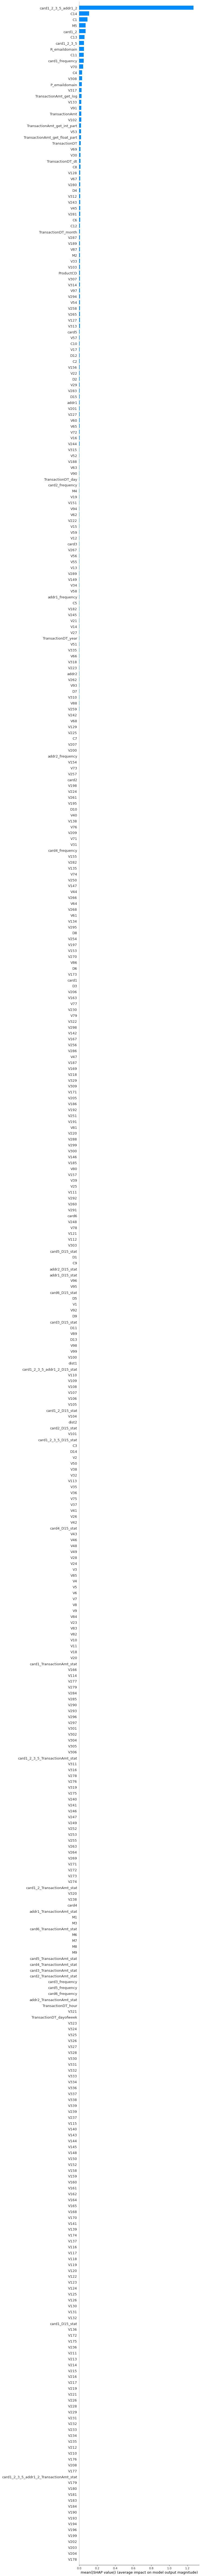

In [48]:
shap.summary_plot(shap_values, x_valid_ce, plot_type="bar", max_display=x_valid_ce.shape[1])

In [49]:
feature_importance = np.abs(pd.DataFrame(shap_values, columns=[x_train_ce.columns])).sum()
# feature_importance = pd.DataFrame(feature_importance, columns=['score'])
feature_importance = pd.DataFrame(feature_importance.values, index=[x_train_ce.columns], columns=['score'])
feature_importance = feature_importance.sort_values(by='score')

In [50]:
important_features = feature_importance[feature_importance['score'] > 0.1].index.tolist()
important_features

[('V248',),
 ('card6',),
 ('V291',),
 ('V260',),
 ('V292',),
 ('V111',),
 ('V25',),
 ('V39',),
 ('V157',),
 ('V80',),
 ('V185',),
 ('V146',),
 ('V300',),
 ('V299',),
 ('V288',),
 ('V220',),
 ('V81',),
 ('V191',),
 ('V251',),
 ('V192',),
 ('V186',),
 ('V205',),
 ('V171',),
 ('V309',),
 ('V329',),
 ('V218',),
 ('V169',),
 ('V187',),
 ('V47',),
 ('V286',),
 ('V256',),
 ('V167',),
 ('V142',),
 ('V298',),
 ('V322',),
 ('V79',),
 ('V230',),
 ('V77',),
 ('V163',),
 ('V206',),
 ('D3',),
 ('card1',),
 ('V173',),
 ('D6',),
 ('V86',),
 ('V270',),
 ('V153',),
 ('V197',),
 ('V254',),
 ('D8',),
 ('V295',),
 ('V134',),
 ('V61',),
 ('V268',),
 ('V64',),
 ('V266',),
 ('V44',),
 ('V147',),
 ('V250',),
 ('V74',),
 ('V135',),
 ('V282',),
 ('V155',),
 ('card4_frequency',),
 ('V31',),
 ('V71',),
 ('V209',),
 ('V76',),
 ('V138',),
 ('V40',),
 ('D10',),
 ('V195',),
 ('V261',),
 ('V224',),
 ('V198',),
 ('card2',),
 ('V257',),
 ('V73',),
 ('V154',),
 ('addr2_frequency',),
 ('V200',),
 ('V207',),
 ('C7',),
 ('V2

In [51]:
def drop_brackets(x):
    return x[0]
important_features = list(map(drop_brackets, important_features))

In [52]:
important_features

['V248',
 'card6',
 'V291',
 'V260',
 'V292',
 'V111',
 'V25',
 'V39',
 'V157',
 'V80',
 'V185',
 'V146',
 'V300',
 'V299',
 'V288',
 'V220',
 'V81',
 'V191',
 'V251',
 'V192',
 'V186',
 'V205',
 'V171',
 'V309',
 'V329',
 'V218',
 'V169',
 'V187',
 'V47',
 'V286',
 'V256',
 'V167',
 'V142',
 'V298',
 'V322',
 'V79',
 'V230',
 'V77',
 'V163',
 'V206',
 'D3',
 'card1',
 'V173',
 'D6',
 'V86',
 'V270',
 'V153',
 'V197',
 'V254',
 'D8',
 'V295',
 'V134',
 'V61',
 'V268',
 'V64',
 'V266',
 'V44',
 'V147',
 'V250',
 'V74',
 'V135',
 'V282',
 'V155',
 'card4_frequency',
 'V31',
 'V71',
 'V209',
 'V76',
 'V138',
 'V40',
 'D10',
 'V195',
 'V261',
 'V224',
 'V198',
 'card2',
 'V257',
 'V73',
 'V154',
 'addr2_frequency',
 'V200',
 'V207',
 'C7',
 'V225',
 'V129',
 'V68',
 'V242',
 'V259',
 'V88',
 'V310',
 'D7',
 'V93',
 'V262',
 'addr2',
 'V223',
 'V318',
 'V66',
 'V335',
 'V51',
 'TransactionDT_year',
 'V27',
 'V14',
 'V21',
 'V245',
 'V182',
 'C5',
 'addr1_frequency',
 'V58',
 'V34',
 'V149',

In [53]:
model_fit(model, 
          x_train_ce[important_features], 
          y_train, 
          x_valid_ce[important_features],
          y_valid,
          x_test_ce[important_features])

0:	test: 0.6522776	test1: 0.6489630	best: 0.6489630 (0)	total: 62.1ms	remaining: 12.4s
100:	test: 0.9422436	test1: 0.8588598	best: 0.8588598 (100)	total: 7.04s	remaining: 6.9s
199:	test: 0.9520571	test1: 0.8752008	best: 0.8752008 (199)	total: 14.3s	remaining: 0us

bestTest = 0.8752007929
bestIteration = 199


model_5:
{'train': 0.9520570529730672, 'valid': 0.8752007929245438, 'test': 0.8626161543959973}


Shap справился не очень хорошо, но, я ничего не настраивал особо

#### Задание 6: 
построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

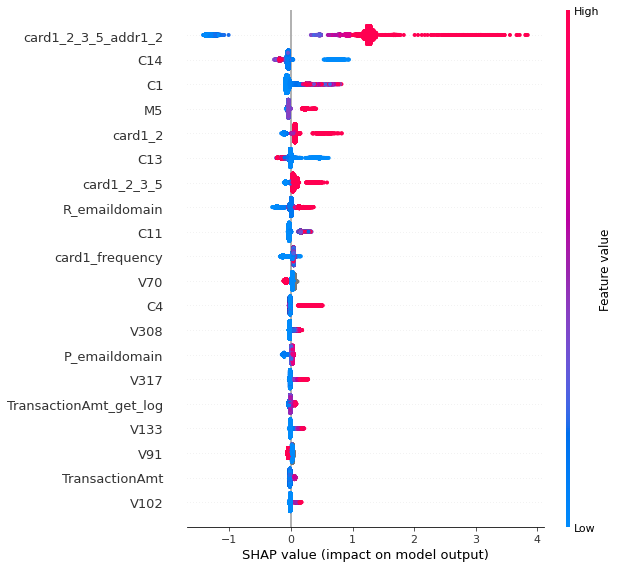

In [54]:
shap.summary_plot(shap_values, x_valid_ce)

Все алгоритмы оценки важности признаков указали самым важным признак card1_2_3_5_addr1_2, собранный в ДЗ №5. 